# Notebook 02 - Exploratory Data Analysis

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

In [2]:
# Load data from previous notebook (original dataset since nothing was changed)
filepath = '..\data\measures_v2.csv'
data = pd.read_csv(filepath)

In [154]:
# Preview data
data.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17


In [155]:
# Let's review the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float64
 1   coolant         1330816 non-null  float64
 2   stator_winding  1330816 non-null  float64
 3   u_d             1330816 non-null  float64
 4   stator_tooth    1330816 non-null  float64
 5   motor_speed     1330816 non-null  float64
 6   i_d             1330816 non-null  float64
 7   i_q             1330816 non-null  float64
 8   pm              1330816 non-null  float64
 9   stator_yoke     1330816 non-null  float64
 10  ambient         1330816 non-null  float64
 11  torque          1330816 non-null  float64
 12  profile_id      1330816 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 132.0 MB


#### Context
The data set comprises several sensor data collected from a permanent magnet synchronous motor (PMSM) deployed on a test bench. The PMSM represents a german OEM's prototype model. Test bench measurements were collected by the LEA department at Paderborn University.

#### Content
All recordings are sampled at 2 Hz. The data set consists of multiple measurement sessions, which can be distinguished from each other by column `profile_id`. A measurement session can be between one and six hours long.

The motor is excited by hand-designed driving cycles denoting a reference motor_speed and a reference torque.
Currents in d/q-coordinates (columns `i_d` and `i_q`) and voltages in d/q-coordinates (columns `u_d` and `u_q`) are a result of a standard control strategy trying to follow the reference speed and torque.
Columns `motor_speed` and `torque` are the resulting quantities achieved by that strategy, derived from set currents and voltages.

Most driving cycles denote random walks in the speed-torque-plane in order to imitate real world driving cycles to a more accurate degree than constant excitations and ramp-ups and -downs would.

#### Target Features
These are the dependent variables of this investigation that we want to be able to predict:
1. `stator_winding`: Stator winding temperature (in °C) measured with thermocouples
2. `stator_tooth`: Stator tooth temperature (in °C) measured with thermocouples
3. `stator_yoke`: Stator yoke temperature (in °C) measured with thermocouples
4. `pm`: Permanent magnet temperature (in °C) measured with thermocouples and transmitted wirelessly via a thermography unit.
5. `torque`: Motor torque (in Nm)

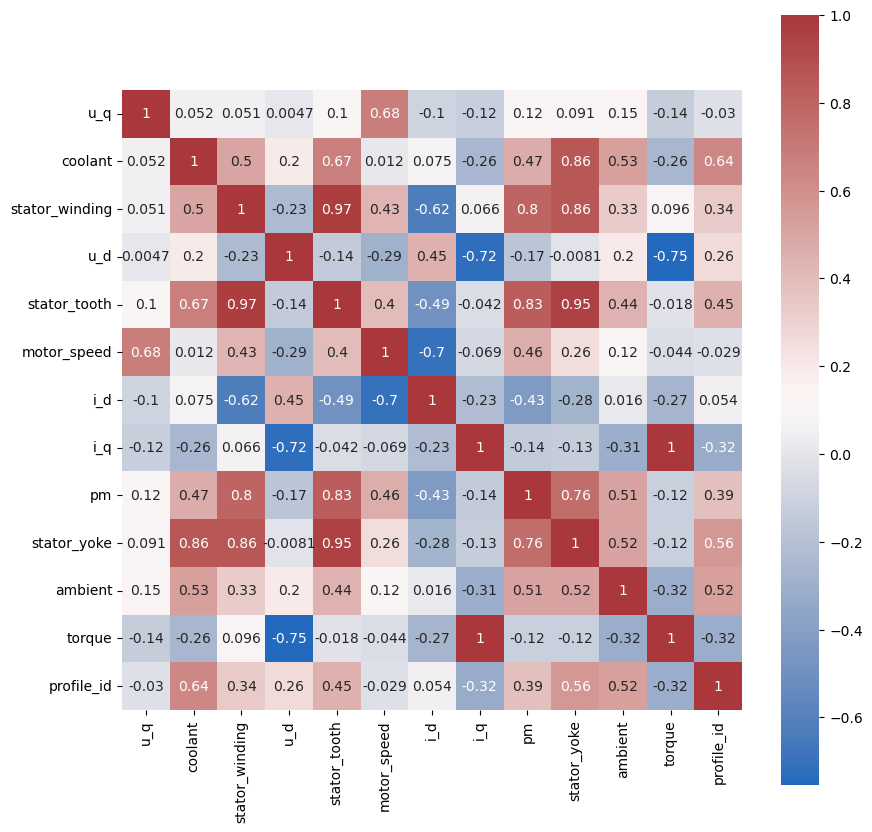

In [156]:
# Let's check out a heat map (with a diverging color palette) of the pearson coeffs between the variables
fig, ax = plt.subplots(figsize=(10,10))  
ax = sns.heatmap(data.corr(), annot=True, square=True, cmap='vlag')
plt.show()

From a first impression:
1. Currents (`i_d` and `i_q`) and voltages (`u_d` and `u_q`) appear to be correlated, as expected.
2. `motor_speed` and `torque` seems to correlate with currents (`i_d` and `i_q`) and voltages (`u_d` and `u_q`), as expected.
3. The `stator_yoke`, `stator_tooth`, `stator_winding` temperatures seem to be correlated with one another.

Let's review the results in a list format.

In [10]:
# function to output a Series of unique correlation coefficients, ignoring repeats (a vs a) and
# permuted indices (a vs b and b vs a)

def get_unique_corr(df):
    
    # calculate corr coeffs
    corr_df = df.corr()
    
    # unstack dataframe (matrix -> list)
    unstacked_df = corr_df.unstack()
    
    # remove same variable comparisons within multi-index
    for k, v in unstacked_df.items():
        if k[0] == k[1]:
            unstacked_df.pop(k)

    # remove permuted multi-index
    duplicates = pd.DataFrame(np.sort(unstacked_df.index.tolist(), axis=1)).duplicated()
    unique_corr = unstacked_df[~(duplicates.values)]
    
    return unique_corr

In [11]:
# call function to produce unique correlation coefficients, then sort
unique_corr = get_unique_corr(data)
unique_corr_sorted = unique_corr.sort_values()

In [12]:
# view most extreme results
print('Most negative:\n--------------')
print(unique_corr_sorted.head(5))
print('\nMost positive:\n--------------')
print(unique_corr_sorted.tail(9))

Most negative:
--------------
u_d             torque   -0.753779
                i_q      -0.723069
motor_speed     i_d      -0.700609
stator_winding  i_d      -0.624370
stator_tooth    i_d      -0.487062
dtype: float64

Most positive:
--------------
u_q             motor_speed     0.683556
pm              stator_yoke     0.756684
stator_winding  pm              0.795893
stator_tooth    pm              0.832084
stator_winding  stator_yoke     0.860268
coolant         stator_yoke     0.860750
stator_tooth    stator_yoke     0.953115
stator_winding  stator_tooth    0.970135
i_q             torque          0.996457
dtype: float64


By sorting the pearson coefficients between the data variables, the most negative relations are between:
1. `u_d` and `torque`
2. `u_d` and `i_q`
3. `i_d` and `motor_speed`
4. `i_d` and `stator_winding`

The most positive relations are between:
1. `i_q` and `torque`
2. `stator_winding` and `stator_tooth`
3. `stator_tooth` and `stator_yoke`
4. `stator_yoke` and `coolant`
5. `stator_winding` and `stator_yoke`
6. `stator_tooth` and `pm`
7. `stator_winding` and `pm`
8. `pm` and `stator_yoke`

However, I am concerned about the correlation of variables across measurement sessions (profile_id). I shall compute the mean pearson correlation coefficients across all measurement sessions to see if there is a difference.

Let's review the unique correlation coefficients again, but this time using the average of the pearson correlation coefficients calculated for each measurement session (i.e. `profile_id`).

In [13]:
# create a copy of data
data_copy = data.copy()

In [14]:
# function to calculate pearson correlation coefficients for the first profile_id in the dataframe
def get_corr_by_id_drop_id(df):
    # get profile_id off top of unique list
    pid = df.profile_id.unique()[0]
    
    # get corr list for this profile_id
    corr_by_pid = df[df.profile_id==pid].corr().unstack().dropna()
    
    # create dict from the corr list
    corr_dict = {str(pid) : corr_by_pid}
    
    # remove data containing this profile_id from dataframe
    df.drop(df[df.profile_id==pid].index, inplace=True)
    
    # output the updated dataframe and the corr coeff dataframe
    return df, pd.DataFrame(corr_dict)

In [15]:
# function to create a datafrmae containing each profile_id's correlations coefficients (as a list) in columns
def build_corr_df(df):
    # initial call to func
    df, corr_df = get_corr_by_id_drop_id(df)
    
    while len(df.profile_id.unique()) > 1:
        df, corr_df_new = get_corr_by_id_drop_id(df)
        corr_df = corr_df.join(corr_df_new, how='left')
    
    return corr_df

In [16]:
# create a dataframe containing a column for each profile_id's correlation coefficients
corr_df = build_corr_df(data_copy)

# take the mean of every column
mean_corr = corr_df.mean(axis=1)

In [17]:
# function to filter for unique correlation coefficients
def filter_for_unique_corr_coeffs(df):
    
    # remove same variable comparisons within multi-index
    for k, v in df.items():
        if k[0] == k[1]:
            df.pop(k)

    # remove permuted multi-index
    duplicates = pd.DataFrame(np.sort(df.index.tolist(), axis=1)).duplicated()
    unique_corr = df[~(duplicates.values)]
    
    return unique_corr

In [18]:
# run the mean correlation coefficient dataframe through the function to filter for only unique correlation coefficients and
# turn the Series into a dataframe
unique_mean_corr_sorted_df = pd.DataFrame({'mean' : filter_for_unique_corr_coeffs(mean_corr).sort_values()})

In [19]:
# join the original correlation coefficients dataframe to the averaged correlation coefficients dataframe
unique_corr_sorted_df = pd.DataFrame({'original' : unique_corr_sorted})
corr_method_compare = unique_corr_sorted_df.join(unique_mean_corr_sorted_df, how='left')

In [20]:
corr_method_compare.head(5)

original      mean
u_d            torque -0.753779 -0.863219
               i_q    -0.723069 -0.843267
motor_speed    i_d    -0.700609 -0.489033
stator_winding i_d    -0.624370 -0.573947
stator_tooth   i_d    -0.487062 -0.482526

In [21]:
corr_method_compare.tail(9)

,,original,mean
u_q,motor_speed,0.683556,0.558888
pm,stator_yoke,0.756684,0.730712
stator_winding,pm,0.795893,0.692733
stator_tooth,pm,0.832084,0.743343
stator_winding,stator_yoke,0.860268,0.920403
coolant,stator_yoke,0.860750,0.592288
stator_tooth,stator_yoke,0.953115,0.975860
stator_winding,stator_tooth,0.970135,0.977644
i_q,torque,0.996457,0.996935


By comparing the correlation coefficients across all measurement sessions in the `original` column to the averaged correlation coefficients of the measurement sessions in the `mean` column, it can be seen that there are a few largely observed differences (i.e. the `coolant` vs `stator_yoke` coefficients). Furthermore, as it doesn't make sense to compare correlations to datapoints between measurement sessions, I will be proceeding with using the mean correlation coefficients across all measurement sessions to describe the data correlations as a whole.

Below are the coefficients sorted according to the mean:

In [22]:
unique_mean_corr_sorted_df.head(4)

mean
u_d            torque -0.863219
               i_q    -0.843267
stator_winding i_d    -0.573947
motor_speed    i_d    -0.489033

In [23]:
unique_mean_corr_sorted_df.tail(12)

,,mean
coolant,stator_winding,0.456377
u_d,i_d,0.516107
coolant,stator_tooth,0.524777
u_q,motor_speed,0.558888
coolant,stator_yoke,0.592288
stator_winding,pm,0.692733
pm,stator_yoke,0.730712
stator_tooth,pm,0.743343
stator_winding,stator_yoke,0.920403
stator_tooth,stator_yoke,0.975860


By sorting the mean pearson coefficients between the data variables, the negative relations greater than 50% are between:
1. `u_d` and `torque`
2. `u_d` and `i_q`
3. `i_d` and `stator_winding`
4. `i_d` and `motor_speed`

The positive relations greater than 50% are between:
1. `i_q` and `torque`
2. `stator_winding` and `stator_tooth`
3. `stator_tooth` and `stator_yoke`
4. `stator_yoke` and `stator_winding`
5. `stator_tooth` and `pm`
6. `stator_yoke` and `pm`
7. `pm` and `stator_winding`
8. `coolant` and `stator_yoke`
9. `u_q` and `motor_speed`
10. `coolant` and `stator_tooth`
11. `u_d` and `i_d`

Now, to verify the above relationships visually, let's review the scatter plots between these variables.

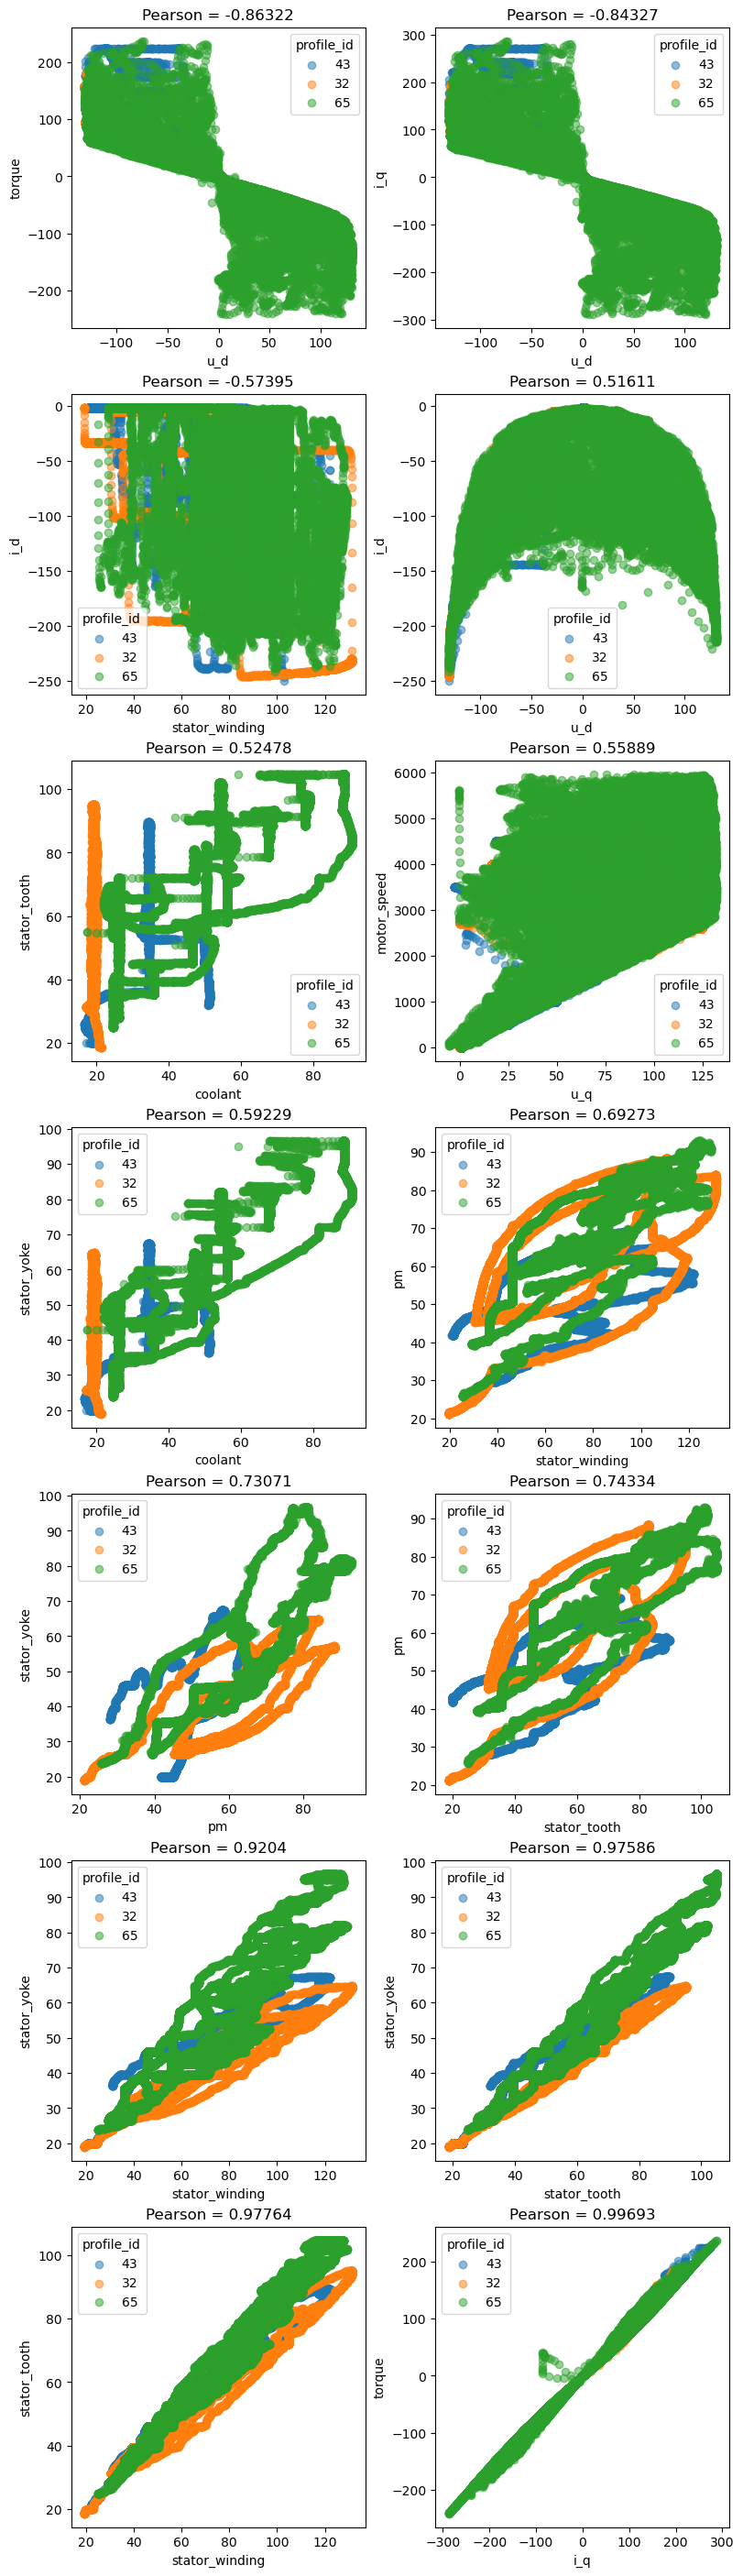

In [93]:
# Get list of indices that have a correlation coefficient greater than 0.5
results = unique_mean_corr_sorted_df.query('mean < -0.5 | mean > 0.5')

# number of profile_ids to plot
n = 3

# get n random profile_ids
r_ids = random.choices(data.profile_id.unique(),k=n)

# For each row of indices:
ncols = 2 # number of subplot columns
row = 0 # initialization
col = 0 # initialization

# Create figure and axes
fig, ax = plt.subplots(nrows=int(results.shape[0]/ncols + results.shape[0]%ncols),
                       ncols=ncols,
                       figsize=(8, 28),
                       constrained_layout=True
                      )
    
for inds in results.index:
    # Get indices of subplot (if cols are fixed)
    if col > ncols-1:
        row += 1
        col = 0
        
    # Plot multi indices against one another in a scatterplot for n random profile_ids (avoids overplotting)
    for r_id in r_ids:
        # scatter plot
        ax[row, col].scatter(data[inds[0]][data.profile_id==r_id], data[inds[1]][data.profile_id==r_id], alpha=0.5)
    
    # Title plots with the corr coefficient and label axes, include legend, etc.
    ax[row, col].set_title('Pearson = ' + str(round(results.loc[inds][0], 5)))
    ax[row, col].set_xlabel(inds[0])
    ax[row, col].set_ylabel(inds[1])
    ax[row, col].legend(r_ids, title='profile_id')
        
    # increase counter
    col += 1
    
plt.show()

It can be noted that pearson coefficients near 0.5 don't necessarily offer useful insight into the relationships between two variables. Correlations may be present, but there is significantly more noise. On the other hand, it's visually represented that measurements with high pearson correlation coefficients (near -1 or 1) are clearly correlated.

Since the variables are recorded over time, let's look at how the measurements change throughout the measurement sessions. 

In [100]:
# For n random profile id's, plot variables against time
def plot_measurements_vs_time(df, n=1, ncols=2):

    # For each row of indices:
    row = 0 # initialization
    col = 0 # initialization

    # Create figure and axes
    fig, ax = plt.subplots(nrows=int(len(df.columns)/ncols + len(df.columns)%ncols),
                           ncols=ncols,
                           figsize=(12, 28),
                           constrained_layout=True
                          )
    
    # for each column variable
    for var in df.columns:
        
        # Get indices of subplot (if cols are fixed)
        if col > ncols-1:
            row += 1
            col = 0
        
        # for each profile_id
        for r_id in r_ids:
            x = [i/2 for i in range(0,len(df[var][df.profile_id==r_id]))] # sampled at 2 Hz
            y = df[var][df.profile_id==r_id]
            ax[row, col].plot(x, y)
        
        ax[row, col].set_xlabel('seconds')
        ax[row, col].set_ylabel(var)
        ax[row, col].legend(r_ids, title='profile_id')
        
        # increase counter
        col += 1
        
    plt.show()

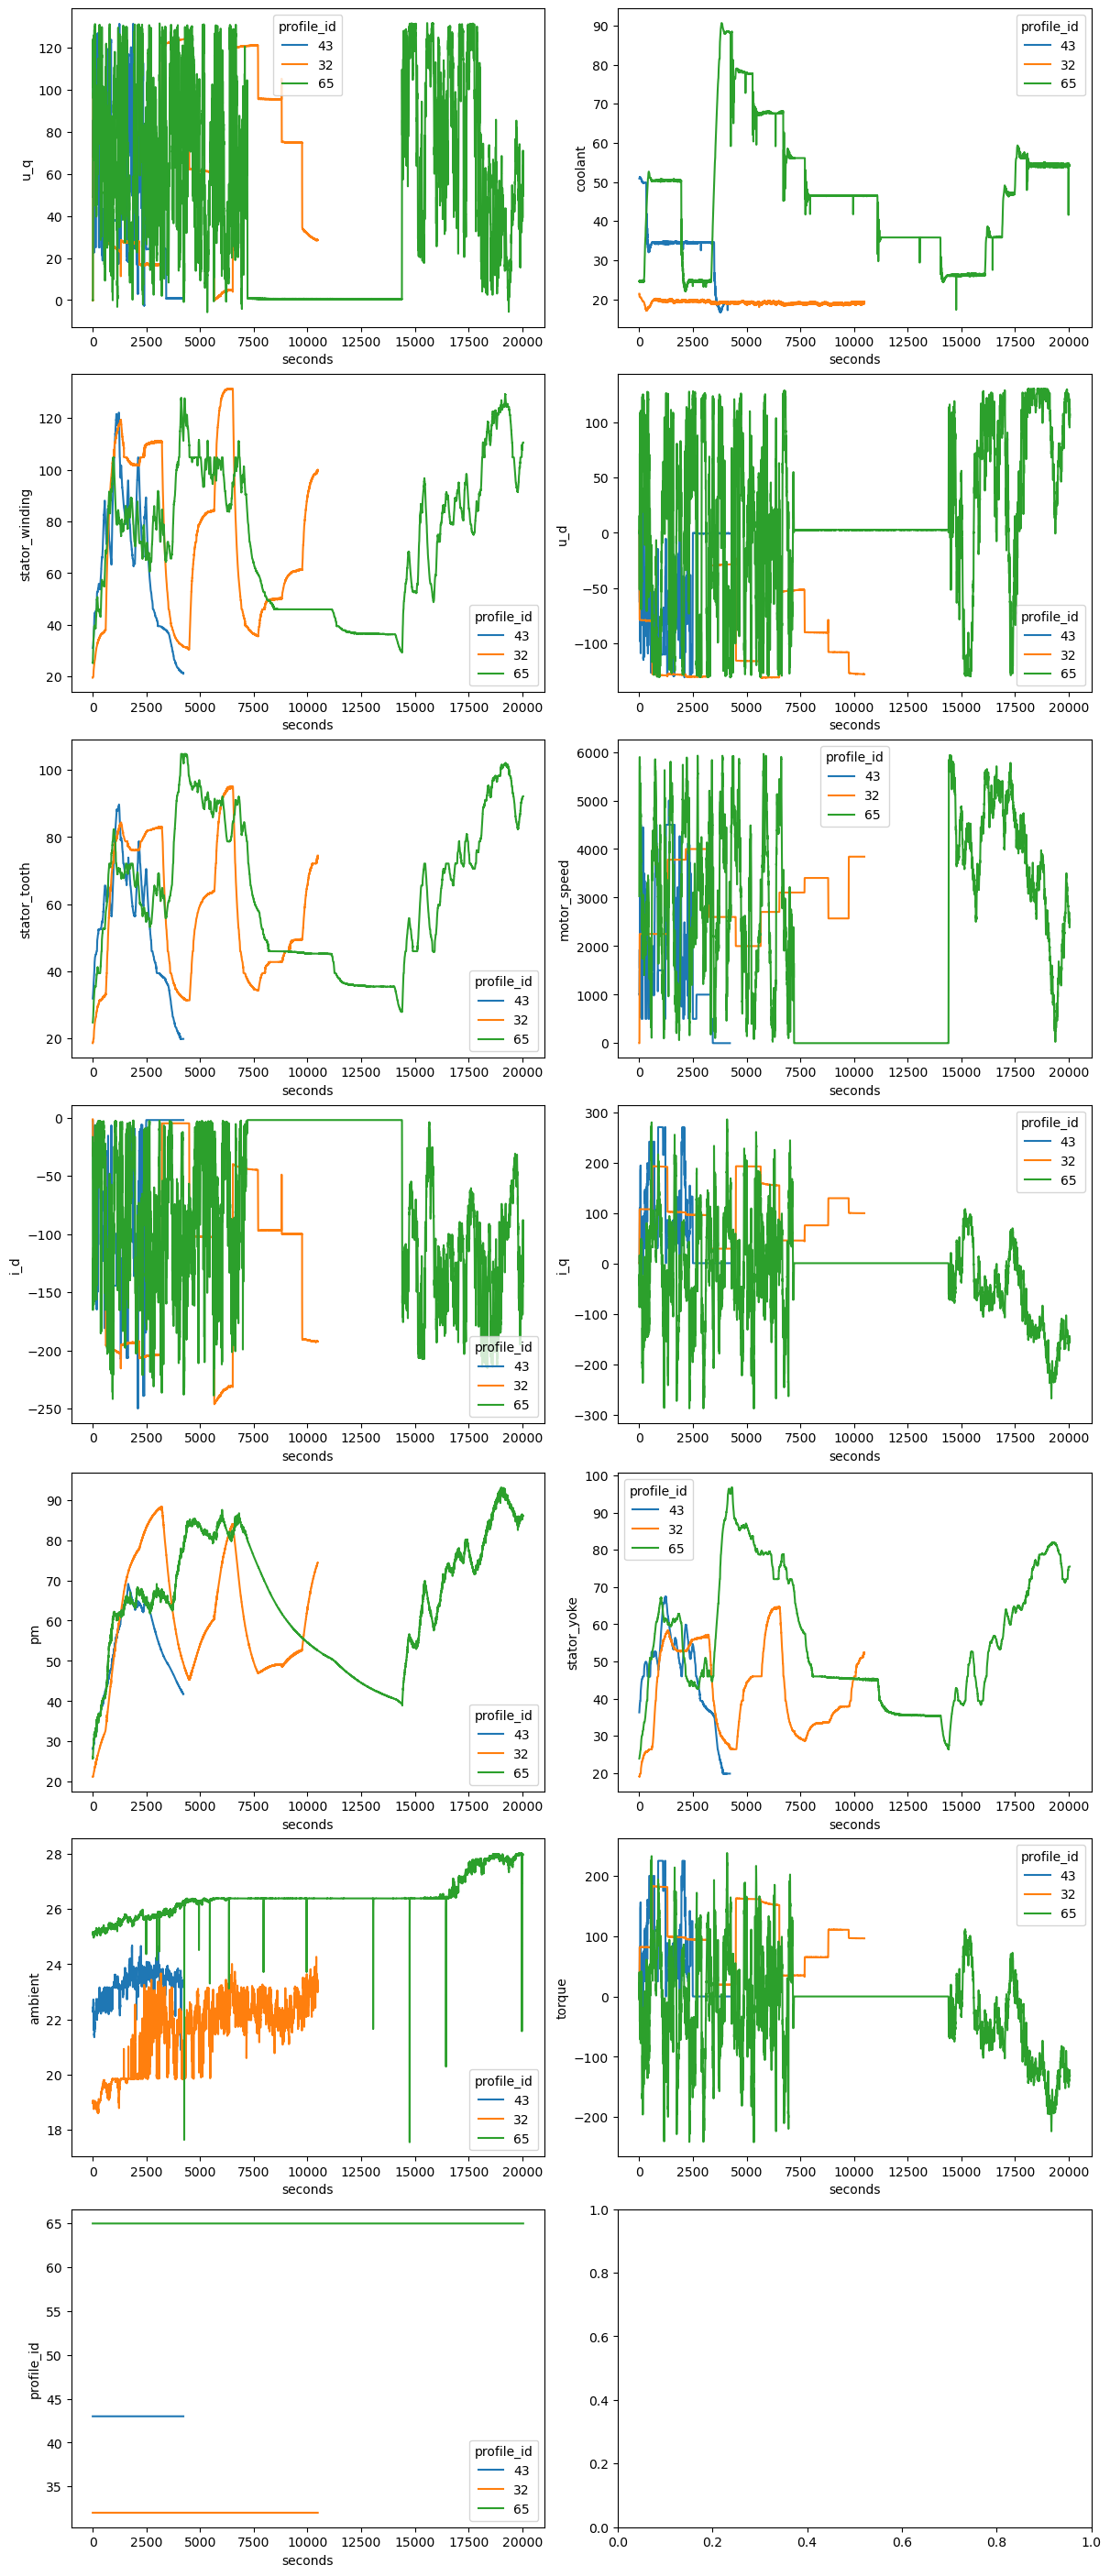

In [102]:
plot_measurements_vs_time(data, n=2, ncols=2)

By plotting the measurements per session against time, it can be confirmed that the length of measurement sessions vary and that a signal can be seen within the noise of each measurement.

When looking at the ambient vs time plot, relatively large spikes in the data can be observed that appear to be inconsistent with the rest of the data. Some filtering can be done when modeling the data later on to take care of this.

Overall, from these plots we can get a sense of how our data changes with time and how well these measurements correlate with one another.

When modeling the data, I would like to look into a multiple linear regression model using the most correlating measurements ranked by the pearson coefficients.